<a href="https://colab.research.google.com/github/sv650s/amazon-review-classification/blob/master/notebooks/deep_learning/6.0.3-LSTMB32-1mil-prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Prototype (Balanced Weights/No Dropout) - 1 million samples


In this notebook, we will use 'balanced' weights calculated by sklearn's compute_class_weight with 1 million training examples to see how this affects our performance. Difference between this notebook and previous notebook is that we have removed dropout from our LSTM.



In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
DRIVE_DIR = "drive/My Drive/Springboard/capstone"
sys.path.append(DRIVE_DIR)


%tensorflow_version 2.x


import tensorflow as tf
# checl to make sure we are using GPU here
tf.test.gpu_device_name()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TensorFlow 2.x selected.


'/device:GPU:0'

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, \
    SpatialDropout1D, Flatten, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import model_to_dot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight


import pandas as pd
import numpy as np
from IPython.display import SVG
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging


import util.dict_util as du
import util.plot_util as pu
import util.file_util as fu
import util.keras_util as ku
import util.report_util as ru



logging.basicConfig(level=logging.ERROR)

%matplotlib inline
sns.set()


DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
LABEL_COLUMN = "star_rating"
REVIEW_COLUMN = "review_body"


DEBUG = False


LSTM_DIM = 32 # total LSTM units
MODEL_NAME = f"LSTMB{LSTM_DIM}"
ARCHITECTURE = f"1x{LSTM_DIM}"
DESCRIPTION = f"1 Layer {LSTM_DIM} LSTM Units, no Dropout - Balanced Weights"
FEATURE_SET_NAME = "random_embedding"
PATIENCE = 4

if DEBUG:
  DATA_FILE = f'{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-test-preprocessed.csv'
  MODEL_NAME = f'test-{MODEL_NAME}'
else:
  DATA_FILE = f"{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-1m-preprocessed.csv"


# first layer filter
FILTER1 = 32
# Network Settings
KERNEL_SIZE=3



# length of our embedding - 300 is standard
EMBED_SIZE = 300
EPOCHS  = 50
BATCH_SIZE = 128

# From EDA, we know that 90% of review bodies have 100 words or less, 
# we will use this as our sequence length
MAX_SEQUENCE_LENGTH = 100



In [0]:
df = pd.read_csv(DATA_FILE)

rating = df[LABEL_COLUMN]
reviews = df[REVIEW_COLUMN]

# Preprocessing

In [4]:


# pre-process our lables
# one hot encode our star ratings since Keras/TF requires this for the labels
y = OneHotEncoder().fit_transform(rating.values.reshape(len(rating), 1)).toarray()


# split our data into train and test sets
reviews_train, reviews_test, y_train, y_test = train_test_split(reviews, y, random_state=1, test_size=0.1)


# Pre-process our features (review body)
t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(reviews_train)
# tokenize both our training and test data
train_sequences = t.texts_to_sequences(reviews_train)
test_sequences = t.texts_to_sequences(reviews_test)

print("Vocabulary size={}".format(len(t.word_counts)))
print("Number of Documents={}".format(t.document_count))


# pad our reviews to the max sequence length
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

print('Train review vectors shape:', X_train.shape, ' Test review vectors shape:', X_test.shape)


Vocabulary size=121775
Number of Documents=896119
Train review vectors shape: (896119, 100)  Test review vectors shape: (99569, 100)


**Build LSTM Model Architecture**

In [0]:
vocab_size = len(t.word_counts)+1

# building our network
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(LSTM_DIM))
model.add(Dense(5, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["categorical_accuracy"])


In [6]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          36532800  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                42624     
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 36,575,589
Trainable params: 36,575,589
Non-trainable params: 0
_________________________________________________________________
None


In [7]:

# reduce learning rate if we sense a plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              # factor=0.4,
                              # patience=PATIENCE, 
                              # min_lr=0.00001,
                             mode='auto')

early_stop = EarlyStopping(monitor='val_loss', 
                           patience=PATIENCE, 
                           verbose=1,
                           restore_best_weights=True)

weights = compute_class_weight('balanced', np.arange(1, 6), rating)
print(f'class weights: {weights}')


mw = ku.ModelWrapper(model, 
                     MODEL_NAME, 
                     ARCHITECTURE,
                     FEATURE_SET_NAME,
                     LABEL_COLUMN, 
                     DATA_FILE, 
                     embed_size=EMBED_SIZE,
                     tokenizer=t,
                     description=DESCRIPTION)

network_history = mw.fit(X_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=1,
                      validation_split=0.2,
                      class_weight=weights,
                      callbacks=[early_stop, reduce_lr])

class weights: [1.42284845 3.02709736 2.2103805  1.20013018 0.37296994]
Number of training examples: 896119
Train on 716895 samples, validate on 179224 samples
Epoch 1/50
716895/716895 [==============================] - 1973s 3ms/sample - loss: 0.8010 - categorical_accuracy: 0.6883 - val_loss: 0.7532 - val_categorical_accuracy: 0.7048
Epoch 2/50
716895/716895 [==============================] - 1968s 3ms/sample - loss: 0.7123 - categorical_accuracy: 0.7205 - val_loss: 0.7451 - val_categorical_accuracy: 0.7087
Epoch 3/50
716895/716895 [==============================] - 1957s 3ms/sample - loss: 0.6655 - categorical_accuracy: 0.7397 - val_loss: 0.7590 - val_categorical_accuracy: 0.7039
Epoch 4/50
716895/716895 [==============================] - 1962s 3ms/sample - loss: 0.6219 - categorical_accuracy: 0.7583 - val_loss: 0.7761 - val_categorical_accuracy: 0.7023
Epoch 5/50
716895/716895 [==============================] - 1965s 3ms/sample - loss: 0.5835 - categorical_accuracy: 0.7748 - val_los

Number of test: 99569
Running model.evaluate...
99569/99569 [==============================] - 21s 208us/sample - loss: 0.7438 - categorical_accuracy: 0.7092
Running model.predict...
Unencode predictions...
Generating confusion matrix...
Calculating ROC AUC...
(99569, 5)
Getting classification report...
Accuracy: 70.92%


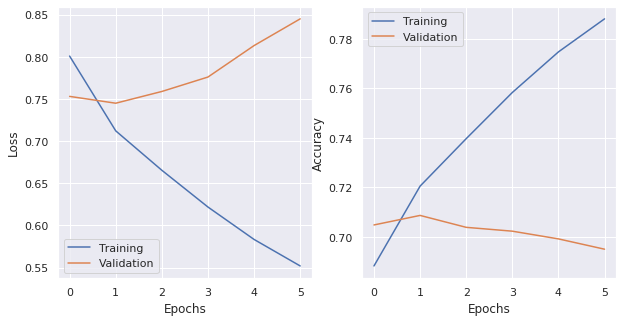


Confusion Matrix
[[11833   698   801   153   711]
 [ 3149   896  1530   348   676]
 [ 1470   602  3309  1691  1947]
 [  384   138  1523  4836  9657]
 [  470    70   529  2409 49739]]

Classification Report
              precision    recall  f1-score   support

           1       0.68      0.83      0.75     14196
           2       0.37      0.14      0.20      6599
           3       0.43      0.37      0.40      9019
           4       0.51      0.29      0.37     16538
           5       0.79      0.93      0.86     53217

    accuracy                           0.71     99569
   macro avg       0.56      0.51      0.52     99569
weighted avg       0.67      0.71      0.68     99569



drive/My Drive/Springboard/capstone/util/plot_util.py:267: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:267: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:271: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:271: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  w

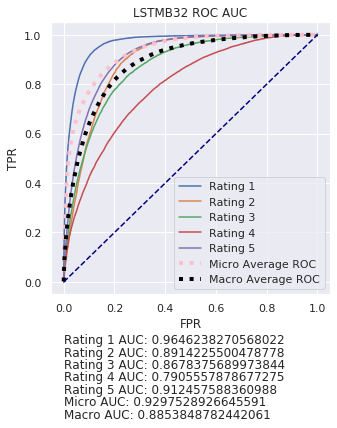

In [8]:

scores = mw.evaluate(X_test, y_test)
print("Accuracy: %.2f%%" % (mw.scores[1]*100))

pu.plot_network_history(mw.network_history, "categorical_accuracy", "val_categorical_accuracy")
plt.show()

print("\nConfusion Matrix")
print(mw.confusion_matrix)

print("\nClassification Report")
print(mw.classification_report)

fig = plt.figure(figsize=(5,5))
pu.plot_roc_auc(mw.model_name, mw.roc_auc, mw.fpr, mw.tpr)



In [9]:
print(f'Score: {ru.calculate_metric(mw.crd)}')

Score: 0.31306351900774754


**Save off various files**

In [10]:
mw.save(DRIVE_DIR, append_report=True)

description: LSTMB32-1x32-random_embedding-sampling_none-995688-100-star_rating
Saving model file: drive/My Drive/Springboard/capstone/models/LSTMB32-1x32-random_embedding-sampling_none-995688-100-star_rating-model.h5
Saving json config file: drive/My Drive/Springboard/capstone/models/LSTMB32-1x32-random_embedding-sampling_none-995688-100-star_rating-model.json
Saving weights file: drive/My Drive/Springboard/capstone/models/LSTMB32-1x32-random_embedding-sampling_none-995688-100-star_rating-weights.h5
Saving to report file: drive/My Drive/Springboard/capstone/reports/2020-02-dl_prototype-report.csv
Loading to append to: drive/My Drive/Springboard/capstone/reports/2020-02-dl_prototype-report.csv
{'model_name': 'LSTMB32', 'architecture': '1x32', 'description': '1 Layer 32 LSTM Units, no Dropout - Balanced Weights', 'classification_report': '{"1": {"precision": 0.6837513001271236, "recall": 0.8335446604677373, "f1-score": 0.7512538886419909, "support": 14196}, "2": {"precision": 0.37271214

In [11]:
print(datetime.now())

2020-02-06 08:35:17.231885
